TODO:

Obligatory
* Add capacity, Reduce overfitting
* Add data and weight initialization randomization
* Investigate why ModelPredictDigit is not converging sometimes
* Try BatchNorm


Optional
* Give to model two samples: positive and negative at one time
* Look and analize where models fail
* Add learning rate scheduler

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import copy

from networks import NetSimple, NetSiamese
from utils import get_accuracy, grid_search, plot_accuracy_and_loss, test_samples, test_model, plot_test_results

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

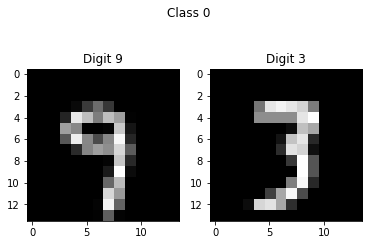

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [7]:
# Task specific setup
input_channels = 2
output_class_channels = 1
output_digit_channels = 10

### Simple model

First let's implement simple model. It;s architecture is based on (LeNet)[] and adapted for current task by adding dropout layers and adjusting filters and neurons number.

In [8]:
net = NetSimple(input_channels, output_class_channels)

In [9]:
def simple_model_criterion(output, target):
    """Loss criterion for simple model: binary cross entropy for class predictons"""
    return binary_cross_entropy(output, target.unsqueeze(1).float())

In [10]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]             152
         MaxPool2d-2              [-1, 8, 6, 6]               0
           Dropout-3              [-1, 8, 6, 6]               0
            Conv2d-4             [-1, 16, 4, 4]           1,168
         MaxPool2d-5             [-1, 16, 2, 2]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 50]           3,250
           Dropout-8                   [-1, 50]               0
            Linear-9                    [-1, 1]              51
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
-----------------------------------------------

### Model with weight sharing

Since we know that in both channels we have digits, its logical to process them in same way. For that we will use same convolution and fully connected layers. At the end we will also add 2 fully connected layers to actually solve our general task of class prediction.

In [11]:
net = NetSiamese(input_channels, output_class_channels, output_digit_channels)

In [12]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         MaxPool2d-2              [-1, 8, 6, 6]               0
           Dropout-3              [-1, 8, 6, 6]               0
            Conv2d-4             [-1, 16, 4, 4]           1,168
         MaxPool2d-5             [-1, 16, 2, 2]               0
            Conv2d-6            [-1, 8, 12, 12]              80
         MaxPool2d-7              [-1, 8, 6, 6]               0
           Dropout-8              [-1, 8, 6, 6]               0
            Conv2d-9             [-1, 16, 4, 4]           1,168
        MaxPool2d-10             [-1, 16, 2, 2]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 25]           1,625
          Dropout-13                   [-1, 25]               0
           Linear-14                   

In [13]:
def siamese_model_criterion(output, target):
    """Loss criterion for siamese model: binary cross entropy for class predictons"""
    return binary_cross_entropy(output, target.unsqueeze(1).float())

One positive side effect of weight sharing in current setup will be that model will have double more data to train first layers. It happens because we divided each sample in our data and obtained twice more samples.

We implemented 4 different version of siamese network which differ in a way of processing results of two subnetworks

In [14]:
siamese_net_versions = NetSiamese.possible_version[:3]  # Removing digit prediction version

### Siamese model with auxiliary loss

In these model we will try to train model to not only predict class but also both digits. For that we will use Siamese network from previous step but also add addtional losses on intermediate fully connected layers

In [15]:
def get_auxiliary_loss_model_criterion(lambda_=1):
    
    def auxiliary_loss_model_criterion(output_class, target_class, output_digits, target_digits):
        """Loss criterion for siamese model with auxiliary loss: 
        binary cross entropy for class predictons, cross entropy for both digit predictions"""
        return lambda_ * binary_cross_entropy(output_class, target_class.unsqueeze(1).float()) \
                + cross_entropy(output_digits[0], target_digits[:, 0]) \
                + cross_entropy(output_digits[1], target_digits[:, 1])

    return auxiliary_loss_model_criterion

### Model for digit preditction

Finnaly, we will make modefication of siamese network ith auxiliary loss in which we will only aim at predicting both digits. Decision about class assignment will be simply done by answering on question *predicted_digit1* <= *predicted_digit2*. In this setting we will remove case when we predict digits correctly but then do mistake when do class prediction. It will make for us easierto detect overfitting in the last layers of network which are precisely responsible for class inferring. 

In [16]:
def digit_prediction_criterion(output_class, target_class, output_digits, target_digits):
    """Loss criterion for siamese model with auxiliary loss: 
    binary cross entropy for class predictons, cross entropy for both digit predictions"""
    return cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[0], target_digits[:, 1])

## Training

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
# device = torch.device("cpu")  # Force to use cpu

In [19]:
def train(train_data_loader, test_data_loader, model, optimizer, criterion, device,
          epochs=10, print_info=False, print_every=5):
    """Trains model"""
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            image, target_class, target_digits = image.to(device), target_class.to(device), target_digits.to(device)
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader, device,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader, device,
                                              calculate_accuracy_digit=model.predicts_digit)
            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            best_accuracy = accuracy_test_class[-1]
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
            
    if print_info:
        print(f"Achieved accuracy: {best_accuracy}")
    return best_model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

#### Simple net

In [20]:
epochs_grid_search = 25
epochs_train = 30

In [21]:
lr_simple_net = 0.01
reg_simple_net = 0.25

In [22]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

lr_simple_net, reg_simple_net = grid_search([0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                              [0.25, 0.1, 0.05, 0.01], # Regularizations
                                              train, train_loader, test_loader, device, 
                                              model_class, model_params, criterion, 
                                              epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.780
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.782
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.777
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.768
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.798
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.781
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.774
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.761
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.744
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.789
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.780
Learning rate: 0.0010, Regularization: 0.01, Test Accuracy: 0.759
Learning rate: 0.0005, Regularization: 0.25, Test Accuracy: 0.749
Learning rate: 0.0005, Regularization: 0.10, Test Accuracy: 0.714
Learning rate: 0.0005, Regularization: 0.05, Test Accuracy: 0.729
Learning r

In [23]:
net_simple = NetSimple(input_channels, output_class_channels, activation="leakyrelu")
optimizer = optim.Adam(net_simple.parameters(), lr=lr_simple_net, weight_decay=reg_simple_net)
criterion = simple_model_criterion

net_simple, accuracies, losses = train(train_loader, test_loader,
                                       net_simple,
                                       optimizer, 
                                       criterion,
                                       device=device,
                                       epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/30, loss 10.8317, class train/test accuracy: 0.553/0.527 
Epoch 10/30, loss 6.9593, class train/test accuracy: 0.803/0.763 
Epoch 15/30, loss 5.6020, class train/test accuracy: 0.876/0.782 
Epoch 20/30, loss 4.4912, class train/test accuracy: 0.899/0.79 
Epoch 25/30, loss 4.1822, class train/test accuracy: 0.918/0.784 
Epoch 30/30, loss 3.3149, class train/test accuracy: 0.91/0.774 
Achieved accuracy: 0.79


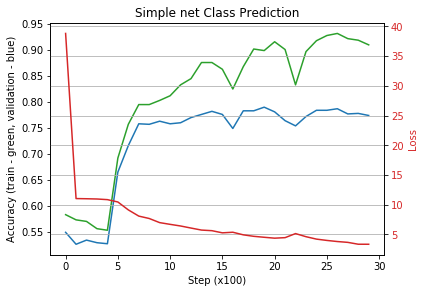

In [24]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

In [25]:
# net_simple_filename = "net_simple.ckpt"
# torch.save(net_simple.state_dict(), net_simple_filename)

#### Siamese network

In [26]:
epochs_grid_search = 25
epochs_train = 30

In [27]:
model_class = NetSiamese
criterion = siamese_model_criterion
lr_siamese_net_all = []
reg_siamese_net_all = []

for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}

    lr_siamese_net, reg_siamese_net = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                  [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                  train, train_loader, test_loader, device, 
                                                  model_class, model_params, criterion, 
                                                  epochs=epochs_grid_search, print_info=True)
    lr_siamese_net_all.append(lr_siamese_net)
    reg_siamese_net_all.append(reg_siamese_net)

Siamese net version 1
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.526
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.532
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.821
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.789
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.809
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.857
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.843
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.851
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.827
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.853
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.845
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.832
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.829
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.846
Learning rate: 0.0010, Regularization: 0.05, Test Accu

Let's see the model's perfomance

Siamese net version 1
Epoch 5/30, loss 5.9396, class train/test accuracy: 0.842/0.818 
Epoch 10/30, loss 5.5970, class train/test accuracy: 0.887/0.815 
Epoch 15/30, loss 4.7466, class train/test accuracy: 0.862/0.822 
Epoch 20/30, loss 4.5596, class train/test accuracy: 0.91/0.812 
Epoch 25/30, loss 3.7885, class train/test accuracy: 0.919/0.838 
Epoch 30/30, loss 3.7477, class train/test accuracy: 0.924/0.84 
Achieved accuracy: 0.849


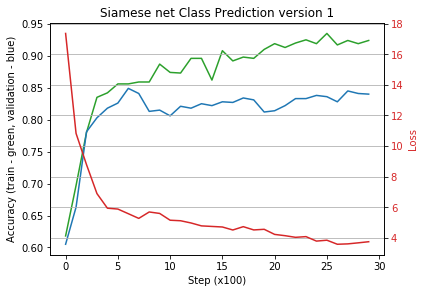

Siamese net version 2
Epoch 5/30, loss 6.7729, class train/test accuracy: 0.82/0.811 
Epoch 10/30, loss 6.0806, class train/test accuracy: 0.848/0.824 
Epoch 15/30, loss 5.8835, class train/test accuracy: 0.857/0.83 
Epoch 20/30, loss 5.3844, class train/test accuracy: 0.858/0.829 
Epoch 25/30, loss 5.3525, class train/test accuracy: 0.874/0.837 
Epoch 30/30, loss 5.2710, class train/test accuracy: 0.87/0.831 
Achieved accuracy: 0.838


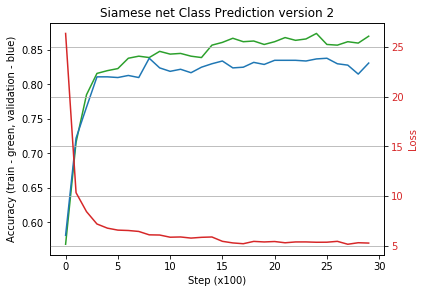

Siamese net version 3
Epoch 5/30, loss 6.1667, class train/test accuracy: 0.85/0.798 
Epoch 10/30, loss 4.9737, class train/test accuracy: 0.878/0.824 
Epoch 15/30, loss 4.5351, class train/test accuracy: 0.9/0.835 
Epoch 20/30, loss 4.1666, class train/test accuracy: 0.908/0.828 
Epoch 25/30, loss 3.9174, class train/test accuracy: 0.922/0.844 
Epoch 30/30, loss 3.7024, class train/test accuracy: 0.923/0.841 
Achieved accuracy: 0.849


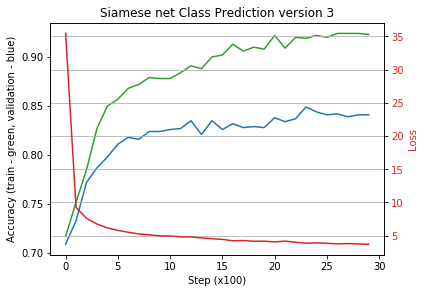

In [28]:
for i, ver in enumerate(siamese_net_versions):
    print(f"Siamese net version {ver}")
    net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu", version=ver)
    optimizer = optim.Adam(net_siamese.parameters(), lr=lr_siamese_net_all[i], weight_decay=reg_siamese_net_all[i])
    criterion = siamese_model_criterion

    net_siamese, accuracies, losses = train(train_loader, test_loader,
                                               net_siamese,
                                               optimizer, 
                                               criterion,
                                               device=device,
                                               epochs=epochs_train, print_info=True)

    accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies
    
    plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, 
                           title=f"Siamese net Class Prediction version {ver}")

In [29]:
# siamese_net_filename = "net_siamese_loss.ckpt"
# torch.save(net_siamese.state_dict(), siamese_net_filename)

#### Digit prediction

In [30]:
epochs_grid_search = 25
epochs_train = 30

In [31]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "auxiliary_loss": True,
                "version": 4}
criterion = digit_prediction_criterion

lr_digit_prediction, reg_digit_prediction = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                      train, train_loader, test_loader, device, 
                                                      model_class, model_params, criterion, 
                                                      epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.833
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.814
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.778
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.834
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.750
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.821
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.526
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.831
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.873
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.877
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.867
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.846
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.590
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.523
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.768
Learning r

Let's see the model's perfomance

In [59]:
net_digit_prediction = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=4)
optimizer = optim.Adam(net_digit_prediction.parameters(), lr=lr_digit_prediction, weight_decay=reg_digit_prediction)
criterion = digit_prediction_criterion

net_digit_prediction, accuracies, losses = train(train_loader, test_loader,
                                                   net_digit_prediction,
                                                   optimizer, 
                                                   criterion,
                                                   device=device,
                                                   epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 72.5756, class train/test accuracy: 0.521/0.497 , digit train/test accuracy: 0.204/0.1775
Epoch 10/30, loss 68.6553, class train/test accuracy: 0.657/0.664 , digit train/test accuracy: 0.431/0.405
Epoch 15/30, loss 64.7657, class train/test accuracy: 0.778/0.792 , digit train/test accuracy: 0.641/0.6325
Epoch 20/30, loss 61.1075, class train/test accuracy: 0.854/0.826 , digit train/test accuracy: 0.7915/0.7695
Epoch 25/30, loss 59.2008, class train/test accuracy: 0.859/0.862 , digit train/test accuracy: 0.8225/0.8085
Epoch 30/30, loss 57.6370, class train/test accuracy: 0.868/0.866 , digit train/test accuracy: 0.8405/0.818
Achieved accuracy: 0.886


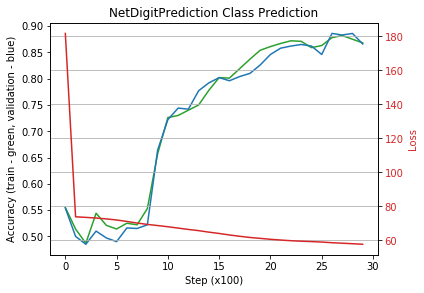

In [60]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetDigitPrediction Class Prediction")

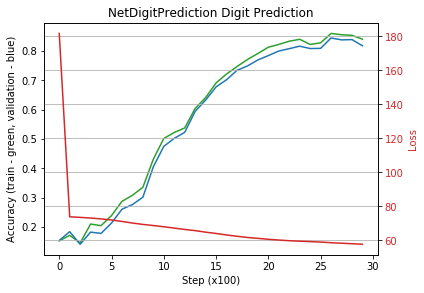

In [61]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetDigitPrediction Digit Prediction")

From these plots we can derive two observations:
* Model is not overfitting at all. That means that all overfitting in siamese network is caused by last layers responsible for predicting class from digit's encodings. 
* Since we don't have overfiting and test error is close to train error we can state that model's capacity is enough for getting at most accuracy of level approximately 85%. 

#### Auxiliary loss

In [35]:
epochs_grid_search = 25
epochs_train = 30

In [36]:
best_lambda = 5

In [37]:
model_class = NetSiamese
criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)
lr_auxiliary_loss_all = []
reg_auxiliary_loss_all = []

for ver in siamese_net_versions:
    print(f"Siamese net version {ver}")
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "auxiliary_loss": True,
                    "version": ver}

    lr_auxiliary_loss, reg_auxiliary_loss = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                                                          [0.25, 0.1, 0.05, 0.01], # Regularizations
                                                          train, train_loader, test_loader, device, 
                                                          model_class, model_params, criterion, 
                                                          epochs=epochs_grid_search, print_info=True)
    
    lr_auxiliary_loss_all.append(lr_auxiliary_loss)
    reg_auxiliary_loss_all.append(reg_auxiliary_loss)

Siamese net version 1
Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.853
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.822
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.855
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.793
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.890
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.848
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.818
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.847
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.860
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.826
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.871
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.843
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.850
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.816
Learning rate: 0.0010, Regularization: 0.05, Test Accu

Let's see the model's perfomance

Siamese net version 1
Epoch 5/30, loss 71.9288, class train/test accuracy: 0.845/0.812 , digit train/test accuracy: 0.694/0.6735
Epoch 10/30, loss 31.6096, class train/test accuracy: 0.896/0.83 , digit train/test accuracy: 0.813/0.7805
Epoch 15/30, loss 23.5327, class train/test accuracy: 0.95/0.856 , digit train/test accuracy: 0.931/0.874
Epoch 20/30, loss 23.1832, class train/test accuracy: 0.931/0.854 , digit train/test accuracy: 0.8825/0.847
Epoch 25/30, loss 18.4659, class train/test accuracy: 0.96/0.855 , digit train/test accuracy: 0.921/0.869
Epoch 30/30, loss 16.3703, class train/test accuracy: 0.971/0.87 , digit train/test accuracy: 0.929/0.884
Achieved accuracy: 0.876


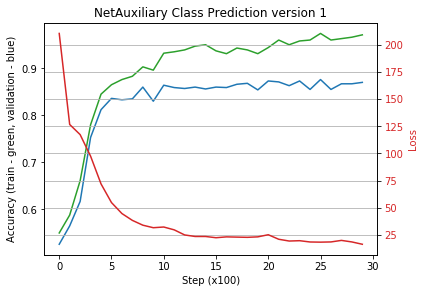

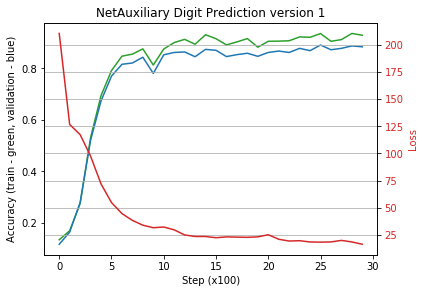

Siamese net version 2
Epoch 5/30, loss 127.7423, class train/test accuracy: 0.564/0.536 , digit train/test accuracy: 0.1585/0.1495
Epoch 10/30, loss 86.6085, class train/test accuracy: 0.804/0.778 , digit train/test accuracy: 0.451/0.423
Epoch 15/30, loss 67.0483, class train/test accuracy: 0.853/0.809 , digit train/test accuracy: 0.4895/0.4825
Epoch 20/30, loss 50.6066, class train/test accuracy: 0.894/0.832 , digit train/test accuracy: 0.759/0.7105
Epoch 25/30, loss 29.8331, class train/test accuracy: 0.949/0.858 , digit train/test accuracy: 0.8365/0.777
Epoch 30/30, loss 30.7924, class train/test accuracy: 0.956/0.866 , digit train/test accuracy: 0.869/0.798
Achieved accuracy: 0.866


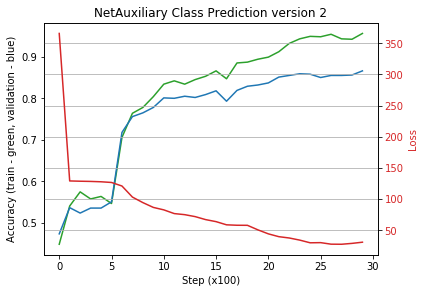

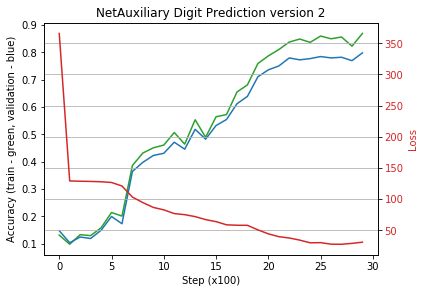

Siamese net version 3
Epoch 5/30, loss 75.3351, class train/test accuracy: 0.818/0.791 , digit train/test accuracy: 0.6295/0.6195
Epoch 10/30, loss 40.4032, class train/test accuracy: 0.888/0.833 , digit train/test accuracy: 0.8505/0.8045
Epoch 15/30, loss 29.5596, class train/test accuracy: 0.912/0.845 , digit train/test accuracy: 0.8825/0.8215
Epoch 20/30, loss 25.4728, class train/test accuracy: 0.943/0.838 , digit train/test accuracy: 0.8945/0.8435
Epoch 25/30, loss 18.2798, class train/test accuracy: 0.959/0.839 , digit train/test accuracy: 0.8955/0.8445
Epoch 30/30, loss 16.2380, class train/test accuracy: 0.949/0.856 , digit train/test accuracy: 0.909/0.861
Achieved accuracy: 0.856


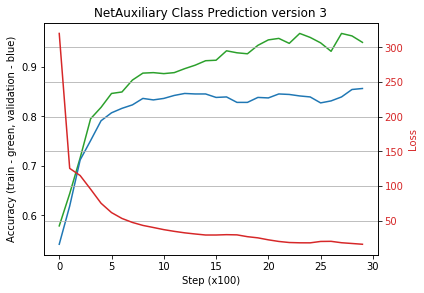

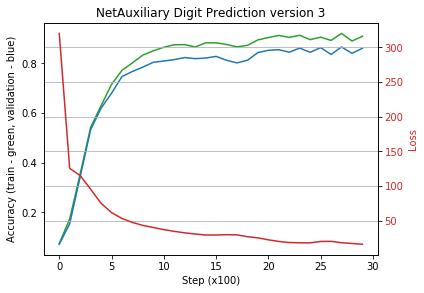

In [38]:
for i, ver in enumerate(siamese_net_versions):
    print(f"Siamese net version {ver}")
    net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, 
                                activation="leakyrelu", auxiliary_loss=True, version=ver)
    optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr_auxiliary_loss_all[i], weight_decay=reg_auxiliary_loss_all[i])
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                                   net_auxiliary_loss,
                                                   optimizer, 
                                                   criterion,
                                                   device=device,
                                                   epochs=epochs_train, print_info=True)

    accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies
    plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, 
                           title=f"NetAuxiliary Class Prediction version {ver}")
    plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, 
                           title=f"NetAuxiliary Digit Prediction version {ver}")

In [39]:
# net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
# torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

### Test

#### Simple net

In [40]:
# checkpoint = torch.load(net_simple_filename)
# net_simple = NetSimple(input_channels, output_class_channels)
# net_simple.load_state_dict(checkpoint)
# # net_simple.to(device)

In [41]:
# test_samples(net_simple, test_input, test_class, test_digit)

#### Weight sharing (Siamese network)

In [42]:
# checkpoint = torch.load(siamese_net_filename)
# net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels)
# net_siamese.load_state_dict(checkpoint)
# # net_simple.to(device)

In [43]:
# test_samples(net_siamese, test_input, test_class, test_digit)

#### Auxiliary loss

In [44]:
# checkpoint = torch.load(net_auxiliary_loss_filename)
# net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, auxiliary_loss=True)
# net_auxiliary_loss.load_state_dict(checkpoint)
# # net_simple.to(device)

In [45]:
# test_samples(net_auxiliary_loss, test_input, test_class, test_digit)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.

In [46]:
nb_tests = 20
epochs_train = 30

#### Simple net

In [47]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels,
                "activation": "leakyrelu"}
criterion = simple_model_criterion

accuracy_values_simple_net, loss_values_simple_net = test_model(train, train_loader, test_loader, device,
                                                                model_class, model_params, criterion, 
                                                                lr_simple_net, reg_simple_net,
                                                                nb_tests=nb_tests, epochs=epochs_train)

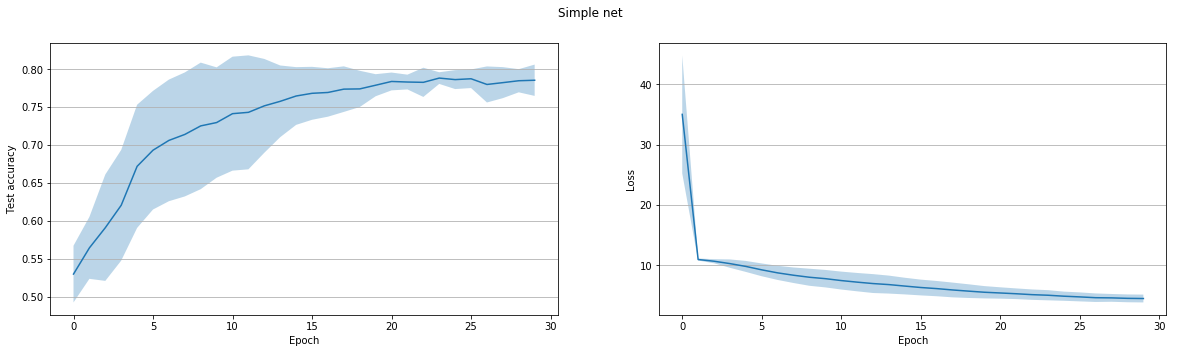

In [48]:
plot_test_results(accuracy_values_simple_net, loss_values_simple_net, title="Simple net")

#### Siamese Net 

Let's try different versions of siamese network

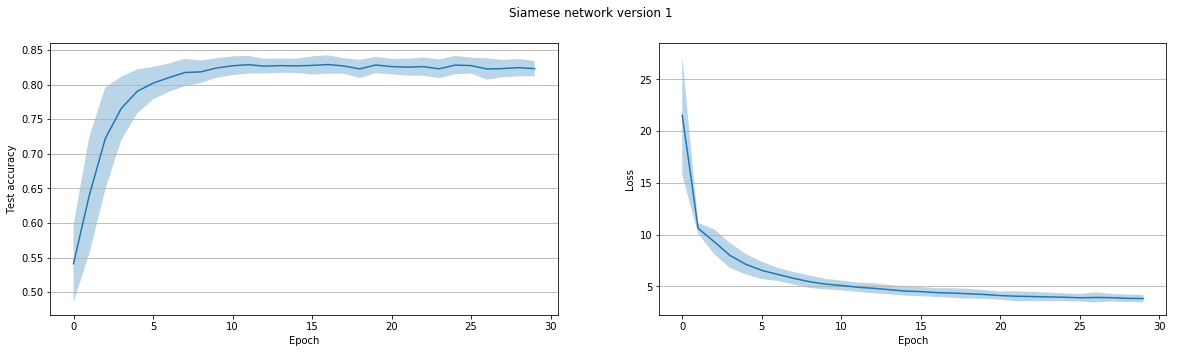

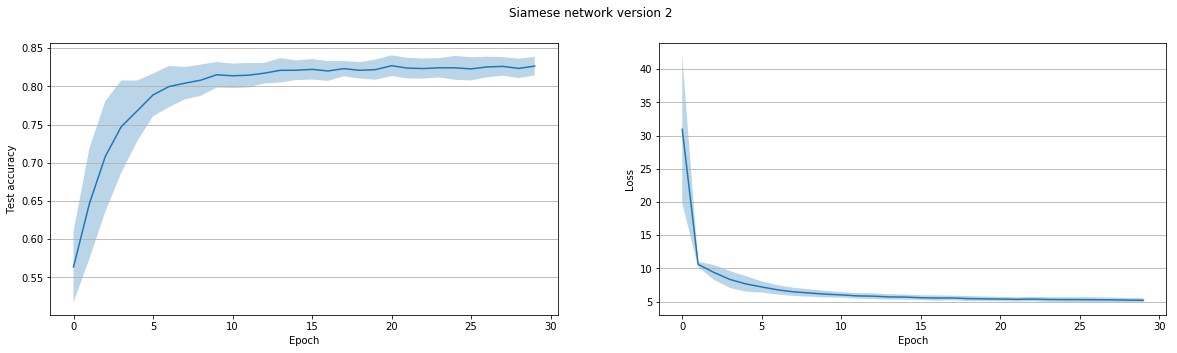

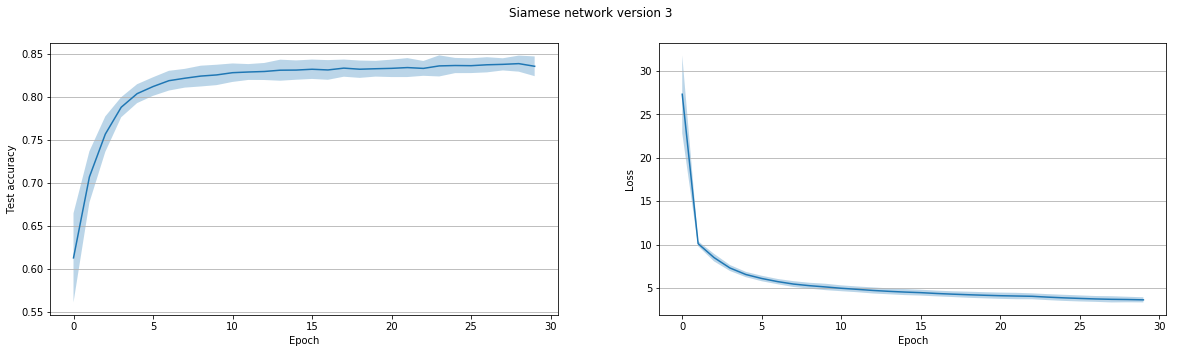

In [49]:
for i, ver in enumerate(siamese_net_versions): 
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver}
    criterion = siamese_model_criterion
    
    accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                              model_class, model_params, criterion, 
                                              lr_siamese_net_all[i], reg_siamese_net_all[i],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network version {ver}")

#### Net for digit prediction

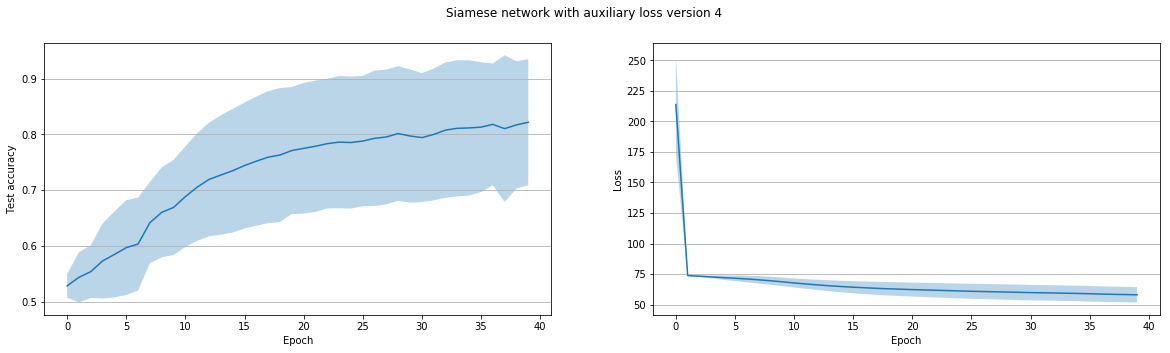

In [62]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "activation": "leakyrelu",
                "version": 4,
                "auxiliary_loss": True}
criterion = digit_prediction_criterion

accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                            model_class, model_params, criterion, lr_digit_prediction, reg_digit_prediction,
                                            nb_tests=nb_tests, epochs=epochs_train+10)

plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {4}")

Plot above reveals that model's results differs a lot from run to run.

In [65]:
for acc in accuracy_values:
    print(acc[-1])

0.849
0.835
0.617
0.535
0.894
0.526
0.883
0.902
0.876
0.859
0.844
0.835
0.894
0.875
0.87
0.857
0.884
0.876
0.857
0.868


In [66]:
for loss in loss_values:
    print(loss[-1])

54.918646574020386
57.62915372848511
69.8557357788086
73.3736686706543
53.729142904281616
73.42312717437744
54.563334465026855
55.088703870773315
56.05363082885742
55.93620753288269
52.72250175476074
55.41565442085266
55.40912747383118
53.091931104660034
53.067545890808105
57.67489743232727
55.089146852493286
54.780805826187134
58.27443051338196
60.082242488861084


Here is strange thing: results from run 3,4 and 6 has very low accuracy level, but there is loss is quite close to another one. It means model converged in not bad minima, however maybe loss metric was not appropriate. But it can't be the case since we use cross entropy which is standard for multiclass classification.

Let's draw results without these runs.

In [70]:
indices = [i for i in range(len(accuracy_values)) if accuracy_values[i][-1] > 0.7]
indices

[0, 1, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [72]:
accuracy_values = [accuracy_values[ind] for ind in indices]
loss_values = [loss_values[ind] for ind in indices]

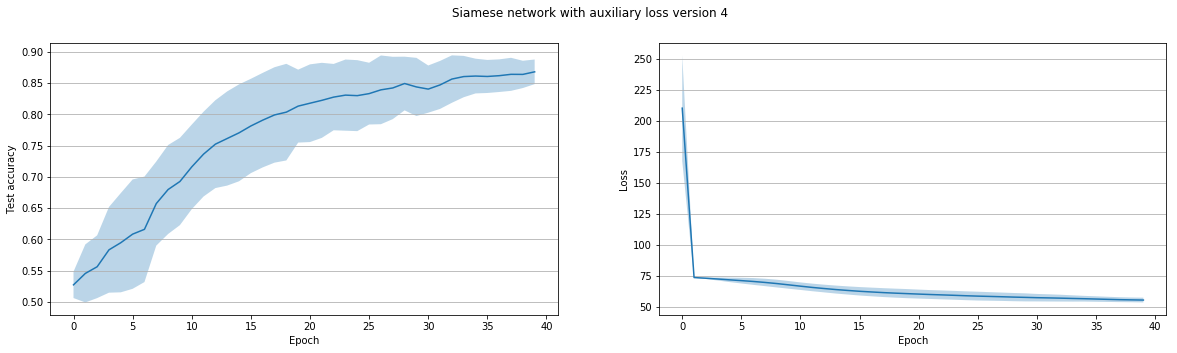

In [73]:
plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {4}")

Way better!

#### Net with AuxiliaryLoss

Let's try different versions of siamese network

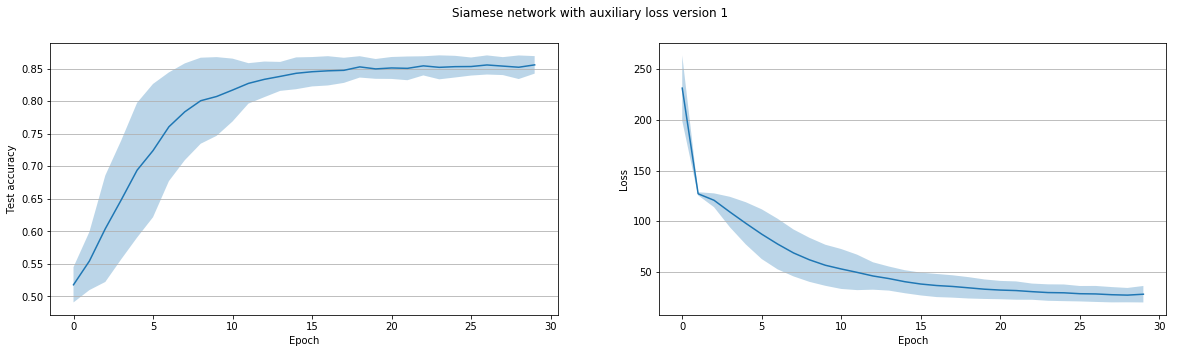

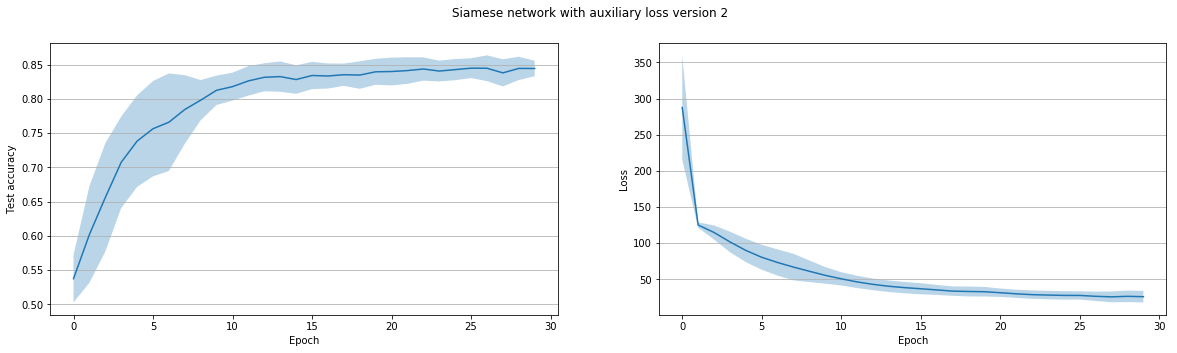

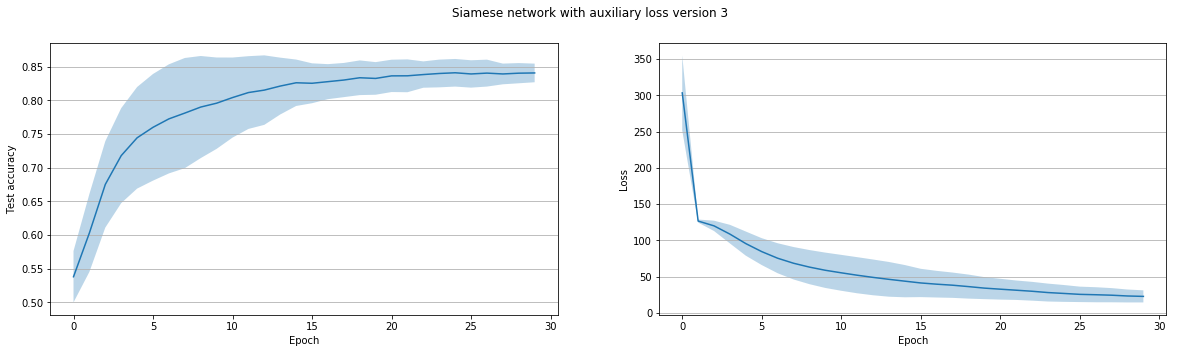

In [51]:
for i, ver in enumerate(siamese_net_versions):
    model_class = NetSiamese
    model_params = {"input_channels": input_channels, 
                    "output_class_channels": output_class_channels, 
                    "output_digit_channels": output_digit_channels,
                    "activation": "leakyrelu",
                    "version": ver,
                    "auxiliary_loss": True}
    criterion = get_auxiliary_loss_model_criterion(lambda_=best_lambda)

    accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                              model_class, model_params, criterion, 
                                              lr_auxiliary_loss_all[i], reg_auxiliary_loss_all[i],
                                              nb_tests=nb_tests, epochs=epochs_train)
    
    plot_test_results(accuracy_values, loss_values, title=f"Siamese network with auxiliary loss version {ver}")

We see that simple net model have accuracy below 80%. Then, turning to siamese arhictecture we increase accuracy to level between 82.5% and 85%. Finnaly, after adding additional loss for sample's both digit prediction we get accuracy approximately 85%.

### Results

#### Simple net

#### Siamese net

#### Net with AuxiliaryLoss

### Model's visualisation

In [52]:
# !pip install graphviz

In [53]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

In [54]:
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [55]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

In [56]:
plot_model_architecture = False

In [57]:
if plot_model_architecture:
    filename = "Simple net"

    inputs = torch.randn(1, 2, 14, 14)
    y = net_simple(Variable(inputs))
    # g = make_dot(y, net_simple.state_dict())
    g = make_dot(y, params=dict(net_simple.named_parameters()))
    g.view(filename)

In [58]:
if plot_model_architecture:
    ver = 2
    filename = f"Siamese version {ver}"
    net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels, activation="leakyrelu", version=ver)

    inputs = torch.randn(1, 2, 14, 14)
    y = net_siamese(Variable(inputs))
    # g = make_dot(y, net_simple.state_dict())
    g = make_dot(y, params=dict(net_siamese.named_parameters()))
    g.view(filename)